In [1]:
!pip install keras_preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 607.9 kB/s eta 0:00:00


In [2]:
import urllib.request
import zipfile
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
import os

In [13]:
data_url = 'https://drive.usercontent.google.com/download?id=1RykmQsicNSuTgzeSWd1uNYW59v-LJ6AJ&export=download&confirm=t'
urllib.request.urlretrieve(data_url, 'Datasets.zip') #testing beberapa sudah terfilter
local_zip = 'Datasets.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('Datasets')
zip_ref.close()

base_dir = 'Datasets'

In [17]:
train_path = os.path.join(f"{base_dir}/Dataset_Split_Fix/train")
val_path = os.path.join(f"{base_dir}/Dataset_Split_Fix/validation")
test_path = os.path.join(f"{base_dir}/Dataset_Split_Fix/test")

# ImageDataGenerator untuk training
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,       # Normalisasi gambar ke rentang [0, 1]
    rotation_range=30,       # Augmentasi: rotasi acak gambar hingga 40 derajat #asli 30
    width_shift_range=0.3,
    height_shift_range=0.2,
    shear_range=0.3,         # Augmentasi: aplikasi transformasi geser
    zoom_range=0.2,          # Augmentasi: zoom gambar hingga 20%
    horizontal_flip=True,    # Augmentasi: flip gambar secara horizontal
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(299, 299),
    batch_size=256,
    class_mode='categorical'
)

# ImageDataGenerator untuk validasi
validation_datagen = ImageDataGenerator(rescale=1.0/255.0)

validation_generator = validation_datagen.flow_from_directory(
    val_path,
    target_size=(299, 299),
    batch_size=128,  #Ganti 64
    class_mode='categorical'
)

# ImageDataGenerator untuk testing
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(299, 299),
    batch_size=128, #Ganti 64
    class_mode='categorical'
)

Found 1062 images belonging to 3 classes.
Found 298 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


In [5]:
import urllib.request
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import Model

# Unduh bobot model InceptionV3
inceptionv3 = 'https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
local_weights_file = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
urllib.request.urlretrieve(inceptionv3, local_weights_file)

# Muat model InceptionV3 tanpa layer top (termasuk layer input dan output)
pre_trained_model = InceptionV3(input_shape=(299, 299, 3),
                                include_top=False,
                                weights=None)
pre_trained_model.load_weights(local_weights_file)

# Bekukan semua layer dari model pra-terlatih
for layer in pre_trained_model.layers:
    layer.trainable = False

# Dapatkan layer terakhir yang diinginkan
last_layer = pre_trained_model.get_layer('mixed7')
last_layer_output = last_layer.output

print(f'Output shape of the last layer (mixed7): {last_layer_output.shape}')


Output shape of the last layer (mixed7): (None, 17, 17, 768)


In [6]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam

# Define the model architecture
x = layers.Conv2D(16, (3, 3), activation='relu')(last_layer_output)
x = layers.MaxPooling2D((2, 2))(x)

# Flatten and add dense layers
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(3, activation='softmax')(x)

# Create the new model
model = Model(pre_trained_model.input, x)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['acc'])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_InceptionV3_model_fix.h5', monitor='val_acc', save_best_only=True)

# Train the model
history = model.fit(train_generator, epochs=100, validation_data=validation_generator, callbacks=[model_checkpoint])


Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 1.1098 - acc: 0.3945

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5/5 [==============================] - 72s 8s/step - loss: 1.1098 - acc: 0.3945 - val_loss: 1.0221 - val_acc: 0.5470
Epoch 2/100
5/5 [==============================] - 39s 7s/step - loss: 0.9765 - acc: 0.5471 - val_loss: 0.8151 - val_acc: 0.6309
Epoch 3/100
5/5 [==============================] - 39s 7s/step - loss: 0.8363 - acc: 0.6121 - val_loss: 0.6740 - val_acc: 0.7517
Epoch 4/100
5/5 [==============================] - 38s 7s/step - loss: 0.7594 - acc: 0.6422 - val_loss: 0.5824 - val_acc: 0.7617
Epoch 5/100
5/5 [==============================] - 38s 9s/step - loss: 0.7276 - acc: 0.6497 - val_loss: 0.6849 - val_acc: 0.6611
Epoch 6/100
5/5 [==============================] - 40s 8s/step - loss: 0.6571 - acc: 0.7109 - val_loss: 0.5130 - val_acc: 0.8020
Epoch 7/100
5/5 [==============================] - 38s 7s/step - loss: 0.6277 - acc: 0.7034 - val_loss: 0.5323 - val_acc: 0.7416
Epoch 8/100
5/5 [==============================] - 38s 7s/step - loss: 0.6008 - acc: 0.7279 - val_loss: 0.448

In [20]:
train_path = os.path.join(f"{base_dir}/Dataset_Split_Fix/train")
val_path = os.path.join(f"{base_dir}/Dataset_Split_Fix/validation")
test_path = os.path.join(f"{base_dir}/Dataset_Split_Fix/test")
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(299, 299),
    batch_size=256,
    class_mode='categorical'
)
validation_datagen = ImageDataGenerator(rescale=1.0/255.0)
validation_generator = validation_datagen.flow_from_directory(
    val_path,
    target_size=(299, 299),
    batch_size=128,
    class_mode='categorical'
)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(299, 299),
    batch_size=128,
    class_mode='categorical'
)

model = tf.keras.models.load_model('best_InceptionV3_model_fix.h5')
train_loss, train_acc = model.evaluate(train_generator)
validation_loss, validation_acc = model.evaluate(validation_generator)
test_loss, test_acc = model.evaluate(test_generator)

print(f"Akurasi pada data Train : {train_acc * 100:.2f}%")
print(f"Akurasi pada data Validation : {validation_acc * 100:.2f}%")
print(f"Akurasi pada data Test : {test_acc * 100:.2f}%")


Found 1062 images belonging to 3 classes.
Found 298 images belonging to 3 classes.
Found 150 images belonging to 3 classes.
2/2 [==============================] - 5s 3s/step - loss: 0.2994 - acc: 0.8933
Akurasi pada data Train : 94.16%
Akurasi pada data Validation : 93.62%
Akurasi pada data Test : 89.33%


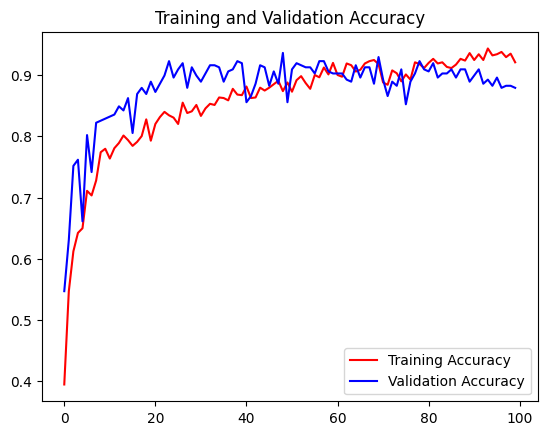

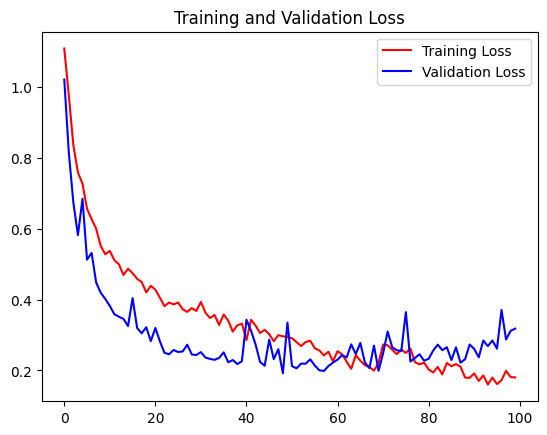

<Figure size 640x480 with 0 Axes>

In [9]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend(loc=0)
plt.figure()
plt.show()

### VALIDASI

Error loading image Datasets/Dataset_Split_Fix/validation/Bagus/desktop.ini: cannot identify image file <_io.BytesIO object at 0x7a50a62a9440>
Error loading image Datasets/Dataset_Split_Fix/validation/Rusak Berat/desktop.ini: cannot identify image file <_io.BytesIO object at 0x7a50b05299e0>
Error loading image Datasets/Dataset_Split_Fix/validation/Rusak Ringan/desktop.ini: cannot identify image file <_io.BytesIO object at 0x7a50a6388cc0>
10/10 [==============================] - 7s 290ms/step


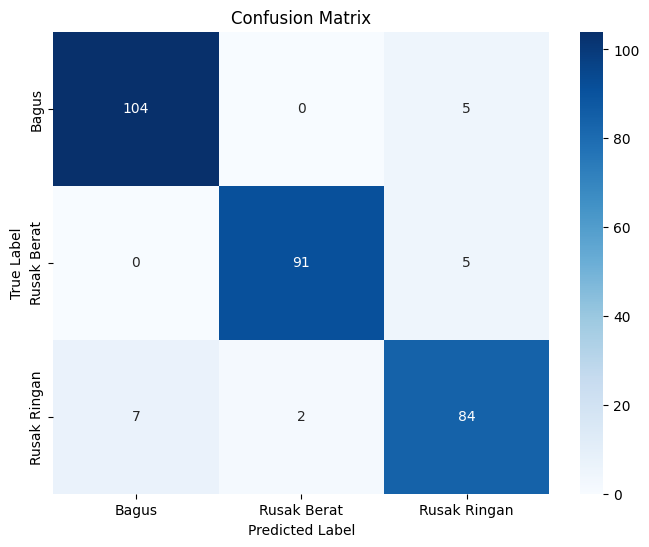


Classification Results :
              precision    recall  f1-score   support

       Bagus       0.94      0.95      0.95       109
 Rusak Berat       0.98      0.95      0.96        96
Rusak Ringan       0.89      0.90      0.90        93

    accuracy                           0.94       298
   macro avg       0.94      0.94      0.94       298
weighted avg       0.94      0.94      0.94       298



In [21]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow import keras
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Specify the new test data folder path
test_data_dir =  val_path # Update this with your actual path
class_names = sorted(os.listdir(test_data_dir))

# Create a function to load and process images
def load_and_process_image(image_path, target_size=(299, 299)):  # InceptionV3 typically uses 299x299 images
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    # Normalize to a range of 0-1
    img_array = img_array / 255.0
    return img_array

# Function to load test data and labels
def load_test_data(test_dir):
    data = []
    labels = []
    class_mapping = {class_name: i for i, class_name in enumerate(class_names)}  # Encoding kelas

    for class_name in class_names:
        class_path = os.path.join(test_dir, class_name)

        # Add folder existence check
        if not os.path.isdir(class_path):
            print(f"Warning: Folder {class_path} not found.")
            continue

        class_label = class_mapping[class_name]
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)

            try:
                img_array = load_and_process_image(image_path)
                data.append(img_array)
                labels.append(class_label)
            except Exception as e:
                print(f"Error loading image {image_path}: {str(e)}")

    return np.array(data), np.array(labels)

# Load model
model = keras.models.load_model('best_InceptionV3_model_fix.h5')  # Update this with your actual path

# Load test data
X_test, y_test = load_test_data(test_data_dir)

# Make predictions using the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(keras.utils.to_categorical(y_test), axis=1)

# Model evaluation
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
classification_rep = classification_report(y_true_classes, y_pred_classes, target_names=class_names)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Show classification report
print("\nClassification Results :")
print(classification_rep)


### TRAIN

Error loading image Datasets/Dataset_Split_Fix/train/Rusak Ringan/desktop.ini: cannot identify image file <_io.BytesIO object at 0x7a5095ba04f0>
34/34 [==============================] - 6s 144ms/step


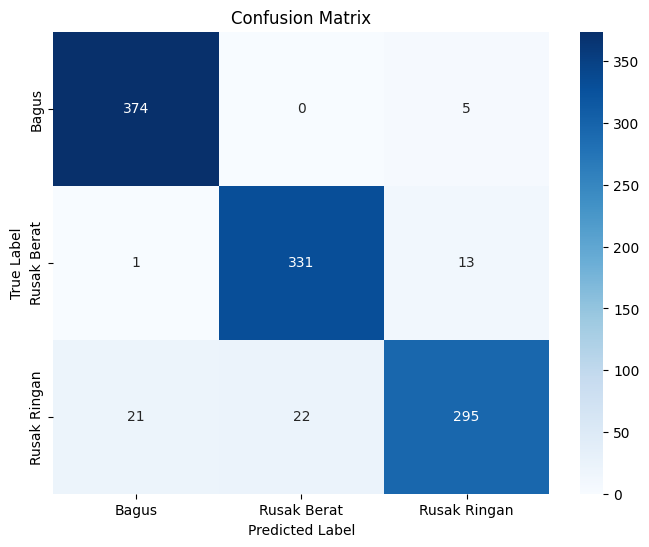


Classification Results :
              precision    recall  f1-score   support

       Bagus       0.94      0.99      0.97       379
 Rusak Berat       0.94      0.96      0.95       345
Rusak Ringan       0.94      0.87      0.91       338

    accuracy                           0.94      1062
   macro avg       0.94      0.94      0.94      1062
weighted avg       0.94      0.94      0.94      1062



In [22]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow import keras
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Specify the new test data folder path
test_data_dir =  train_path # Update this with your actual path
class_names = sorted(os.listdir(test_data_dir))

# Create a function to load and process images
def load_and_process_image(image_path, target_size=(299, 299)):  # InceptionV3 typically uses 299x299 images
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    # Normalize to a range of 0-1
    img_array = img_array / 255.0
    return img_array

# Function to load test data and labels
def load_test_data(test_dir):
    data = []
    labels = []
    class_mapping = {class_name: i for i, class_name in enumerate(class_names)}  # Encoding kelas

    for class_name in class_names:
        class_path = os.path.join(test_dir, class_name)

        # Add folder existence check
        if not os.path.isdir(class_path):
            print(f"Warning: Folder {class_path} not found.")
            continue

        class_label = class_mapping[class_name]
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)

            try:
                img_array = load_and_process_image(image_path)
                data.append(img_array)
                labels.append(class_label)
            except Exception as e:
                print(f"Error loading image {image_path}: {str(e)}")

    return np.array(data), np.array(labels)

# Load model
model = keras.models.load_model('best_InceptionV3_model_fix.h5')  # Update this with your actual path

# Load test data
X_test, y_test = load_test_data(test_data_dir)

# Make predictions using the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(keras.utils.to_categorical(y_test), axis=1)

# Model evaluation
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
classification_rep = classification_report(y_true_classes, y_pred_classes, target_names=class_names)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Show classification report
print("\nClassification Results :")
print(classification_rep)


### TEST

Error loading image Datasets/Dataset_Split_Fix/test/Bagus/desktop.ini: cannot identify image file <_io.BytesIO object at 0x7a50987c4d10>
Error loading image Datasets/Dataset_Split_Fix/test/Rusak Berat/desktop.ini: cannot identify image file <_io.BytesIO object at 0x7a5098589670>
5/5 [==============================] - 1s 107ms/step


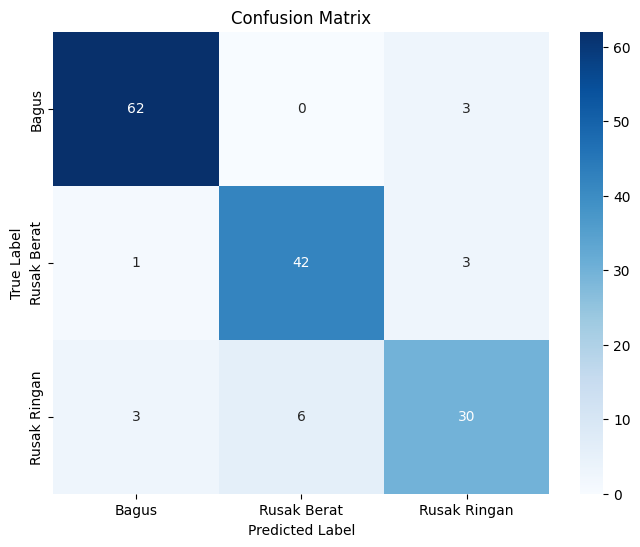


Classification Results :
              precision    recall  f1-score   support

       Bagus       0.94      0.95      0.95        65
 Rusak Berat       0.88      0.91      0.89        46
Rusak Ringan       0.83      0.77      0.80        39

    accuracy                           0.89       150
   macro avg       0.88      0.88      0.88       150
weighted avg       0.89      0.89      0.89       150



In [23]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow import keras
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Specify the new test data folder path
test_data_dir =  test_path # Update this with your actual path
class_names = sorted(os.listdir(test_data_dir))

# Create a function to load and process images
def load_and_process_image(image_path, target_size=(299, 299)):  # InceptionV3 typically uses 299x299 images
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    # Normalize to a range of 0-1
    img_array = img_array / 255.0
    return img_array

# Function to load test data and labels
def load_test_data(test_dir):
    data = []
    labels = []
    class_mapping = {class_name: i for i, class_name in enumerate(class_names)}  # Encoding kelas

    for class_name in class_names:
        class_path = os.path.join(test_dir, class_name)

        # Add folder existence check
        if not os.path.isdir(class_path):
            print(f"Warning: Folder {class_path} not found.")
            continue

        class_label = class_mapping[class_name]
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)

            try:
                img_array = load_and_process_image(image_path)
                data.append(img_array)
                labels.append(class_label)
            except Exception as e:
                print(f"Error loading image {image_path}: {str(e)}")

    return np.array(data), np.array(labels)

# Load model
model = keras.models.load_model('best_InceptionV3_model_fix.h5')  # Update this with your actual path

# Load test data
X_test, y_test = load_test_data(test_data_dir)

# Make predictions using the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(keras.utils.to_categorical(y_test), axis=1)

# Model evaluation
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
classification_rep = classification_report(y_true_classes, y_pred_classes, target_names=class_names)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Show classification report
print("\nClassification Results :")
print(classification_rep)
